### **One Class Support Vector Machine (OCSVM)**

### **1. Access to the DeepFake real and fake data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Unzip the our data
!unzip -qq "/content/drive/MyDrive/deepfake_dataset_OCSVM.zip"  -d "/content"

replace /content/deepfake_dataset/test/fake/frame0_face_0001.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# Set the directories to training, validation and test data
train_data_path = './deepfake_dataset/train/'
validation_data_path = './deepfake_dataset/validation/'
test_data_path = './deepfake_dataset/test/'

In [ ]:
# List out all image file name in the folders
from glob import glob # This library used to get all file in folder
from tqdm import tqdm # This lbrary used to show progress bar
import numpy as np
import cv2
width = 32 # Reshape image to new width
height = 32 # Reshape image to new height

def get_img_file(directory):
  """
  Get all real and fake file name in the directory, label real as 0s and fake as 1s
  """
  real_list = glob(directory + "real/*.jpg")
  fake_list = glob(directory + "fake/*.png")
  file_list = real_list + fake_list

  real_lb = [0] * len(real_list)
  fake_lb = [1] * len(fake_list)
  label_list = real_lb+fake_lb

  num_imgs = len(label_list)
  imgs = np.zeros((num_imgs, width, height, 3), dtype=np.int16)

  for idx, file in tqdm(enumerate(file_list)):
    img_bgr = cv2.imread(file) # Read image
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_resize = cv2.resize(img_rgb, (width, height), interpolation = cv2.INTER_AREA) # Resize image
    imgs[idx] = img_resize

  return imgs, np.array(label_list)

train_imgs, train_lbs = get_img_file(train_data_path)
val_imgs, val_lbs = get_img_file(validation_data_path)
test_imgs, test_lbs = get_img_file(test_data_path)

6989it [00:03, 2146.15it/s]
2003it [00:05, 334.08it/s]
4022it [00:09, 410.88it/s]


### **2. Visualize some random images in training set**

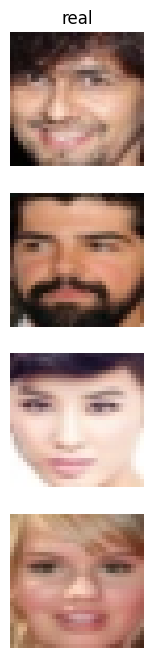

In [ ]:
from matplotlib import pyplot as plt
classes = ['real']
num_classes = len(classes)
samples_per_class = 4
plt.figure(figsize=(8,8))
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(train_lbs == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(train_imgs[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()


### **3. Transform the dataset**
Our (train / val / test) input data have the shape of 4-D matrix `num_images x width x height x 3`, where 3 is the number of channels of each imag (Red, Green and Blue channel).
To fix into our SVM model, each of train / val / test dataset are transformed to a 2D matrix `num_images x F`, where `F = width x height x 3`.

In [ ]:
print('Training data shape: ', train_imgs.shape)
print('Validation labels shape: ' , val_imgs.shape)
print('Test data shape: ', test_imgs.shape)

Training data shape:  (6989, 32, 32, 3)
Validation labels shape:  (2003, 32, 32, 3)
Test data shape:  (4022, 32, 32, 3)


In [ ]:
import numpy as np

train_imgs_trans = train_imgs.reshape(train_imgs.shape[0], -1)
val_imgs_trans = val_imgs.reshape(val_imgs.shape[0], -1)
test_imgs_trans = test_imgs.reshape(test_imgs.shape[0], -1)

print('Transformed training data shape: ', train_imgs_trans.shape)
print('Transformed validation data shape: ', val_imgs_trans.shape)
print('Transformed test data shape: ', test_imgs_trans.shape)

train_imgs_trans = train_imgs.reshape(-1, width*height*3)
val_imgs_trans = val_imgs.reshape(-1, width*height*3)
test_imgs_trans = test_imgs.reshape(-1, width*height*3)

Transformed training data shape:  (6989, 3072)
Transformed validation data shape:  (2003, 3072)
Transformed test data shape:  (4022, 3072)


In [ ]:
# Sanity check new shape of input data
print(train_imgs_trans.shape == (len(train_imgs), width*height*3))
print(val_imgs_trans.shape == (len(val_imgs), width*height*3))
print(test_imgs_trans.shape == (len(test_imgs), width*height*3))

True
True
True


**Question 2.** Now, to normalize the data, you are asked to calculate the mean of training data set. The mean vector will have the shape of `F`. And then subtract the mean from the training / val / test dataset.

**Answer.**

The code calculates the mean vector of the training dataset (train_mean) by averaging the pixel values across all images. This vector represents the average pixel value for each position across all training images. A sanity check verifies that the shape of the mean vector matches the expected dimensions. Then, the code normalizes the training, validation, and test datasets by subtracting this mean vector from each dataset's corresponding reshaped 2D array.

In [ ]:
temp_mean_value = train_imgs_trans.mean() # mean value
train_mean = np.full((width*height*3,), temp_mean_value) # fill array with mean value

# Sanity check shape of mean vector
print(train_mean.shape == (width*height*3,))

# Subtract mean from train / val / test
train_imgs_norm = train_imgs_trans - train_mean
val_imgs_norm = val_imgs_trans - train_mean
test_imgs_norm = test_imgs_trans - train_mean

True


### **4. One Class Support Vector Machine**

One-Class SVM (Support Vector Machine) is an unsupervised learning algorithm used for anomaly detection. It is particularly useful when the task involves identifying whether a data point belongs to a certain class or not, based on training data that contains only examples of that class.

### How One-Class SVM Works

1. **Training Phase**:
    - The algorithm is trained on a dataset that contains only examples of the normal class.  <font color=#FF0000>**For our assignment, we will only train real class in train set.**</font>
    - It constructs a hyperplane that maximizes the distance from the origin to the nearest data points, effectively enclosing the normal data points within a boundary in the feature space.

2. **Testing Phase**:
    - When a new data point is presented, the algorithm determines its position relative to the hyperplane.
    - If the data point lies within the boundary defined by the hyperplane, it is considered normal.
    - If it lies outside this boundary, it is flagged as an anomaly.
    - <font color=#FF0000>**For our assignment, we will test both class in validation set and test set.**</font>

<font color=#FF0000>**OC-SVM don't take any labels for training and validation, for calculating accuracy in validation and test, you need to choose threshold value for comparing with ground truth by yourself. for more instruction, follow this; https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html**</font>


### Mathematical Formulation

The objective of One-Class SVM is to solve the following optimization problem:

$$ \min_{\mathbf{w}, \rho, \xi_i} \frac{1}{2} \|\mathbf{w}\|^2 + \frac{1}{\nu n} \sum_{i=1}^n \xi_i - \rho $$

subject to:

$$ (\mathbf{w} \cdot \phi(\mathbf{x}_i)) \geq \rho - \xi_i, \quad \xi_i \geq 0, \quad i = 1, \ldots, n $$

where:
- $\mathbf{w}$ is the normal vector to the hyperplane.
- $\phi(\mathbf{x}_i)$ is the feature mapping function.
- $\rho$ is the offset from the origin.
- $\xi_i$ are slack variables that allow for some data points to lie within the margin.
- $\nu$ is a parameter that controls the trade-off between maximizing the margin and minimizing the number of anomalies (outliers).

### Dual Formulation

The primal problem can be converted into a dual problem using Lagrange multipliers. The dual form is typically more efficient to solve and is given by:

$$ \max_{\alpha} -\frac{1}{2} \sum_{i,j=1}^n \alpha_i \alpha_j K(\mathbf{x}_i, \mathbf{x}_j) $$

subject to:

$$ 0 \leq \alpha_i \leq \frac{1}{\nu n}, \quad \sum_{i=1}^n \alpha_i = 1 $$

where:
- $\alpha_i$ are the Lagrange multipliers.
- $K(\mathbf{x}_i, \mathbf{x}_j) = \phi(\mathbf{x}_i) \cdot \phi(\mathbf{x}_j)$ is the kernel function.

### Decision Function

After solving the dual problem, the decision function is given by:

$$ f(\mathbf{x}) = \sum_{i=1}^n \alpha_i K(\mathbf{x}_i, \mathbf{x}) - \rho $$

A new data point $\mathbf{x}$ is classified as follows:
- If $f(\mathbf{x}) \geq 0$, the point is considered normal.
- If $f(\mathbf{x}) < 0$, the point is considered an anomaly.

### Kernels

The kernel function $K(\mathbf{x}_i, \mathbf{x}_j)$ can be chosen based on the problem at hand. Common choices include:
- Linear kernel: $K(\mathbf{x}_i, \mathbf{x}_j) = \mathbf{x}_i \cdot \mathbf{x}_j$
- Polynomial kernel: $K(\mathbf{x}_i, \mathbf{x}_j) = (\mathbf{x}_i \cdot \mathbf{x}_j + c)^d$
- Radial basis function (RBF) kernel: $K(\mathbf{x}_i, \mathbf{x}_j) = \exp\left(-\gamma \|\mathbf{x}_i - \mathbf{x}_j\|^2\right)$




#### **4.1 One Class Support vector machine with `linear` kernel**
Precison, Recall, F1, and accuracy of *validation set* of One Class SVM model with `linear` kernel, trade-off parameter `ν = 0.7`.
> **Result.**
- Precision (Linear Kernel): 0.5366
- Recall (Linear Kernel): 0.8265
- F1 Score (Linear Kernel): 0.6507
- Accuracy (Linear Kernel): 0.5557

In [ ]:
from sklearn.svm import OneClassSVM
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

ocsvm_linear = OneClassSVM(kernel='linear', nu=0.7)
real_train_imgs_norm = train_imgs_norm[train_lbs == 0] # Only train 'real' class
ocsvm_linear.fit(real_train_imgs_norm)

In [ ]:
val_preds_linear = ocsvm_linear.predict(val_imgs_norm)
val_preds_linear = np.where(val_preds_linear == 1, 0, 1)

precision_linear = precision_score(val_lbs, val_preds_linear)
recall_linear = recall_score(val_lbs, val_preds_linear)
f1_linear = f1_score(val_lbs, val_preds_linear)
accuracy_linear = accuracy_score(val_lbs, val_preds_linear)

print(f"Precision (Linear Kernel): {precision_linear:.4f}")
print(f"Recall (Linear Kernel): {recall_linear:.4f}")
print(f"F1 Score (Linear Kernel): {f1_linear:.4f}")
print(f"Accuracy (Linear Kernel): {accuracy_linear:.4f}")

Precision (Linear Kernel): 0.5366
Recall (Linear Kernel): 0.8265
F1 Score (Linear Kernel): 0.6507
Accuracy (Linear Kernel): 0.5557


#### **4.2 One Class Support vector machine with `rbf` kernel**
Precison, Recall, F1, and accuracy of *validation set* of OCSVM model with `rbf` kernel, trade-off parameter `ν = 0.7`.
> **Result.**
- Precision (RBF Kernel): 0.3704
- Recall (RBF Kernel): 0.4317
- F1 Score (RBF Kernel): 0.3987
- Accuracy (RBF Kernel): 0.3480

In [ ]:
ocsvm_rbf = OneClassSVM(kernel='rbf', nu=0.7)
real_train_imgs_norm = train_imgs_norm[train_lbs == 0] # Only train 'real' class
ocsvm_rbf.fit(real_train_imgs_norm)

OneClassSVM(nu=0.7)

In [ ]:
val_preds_rbf = ocsvm_rbf.predict(val_imgs_norm)
val_preds_rbf = np.where(val_preds_rbf == 1, 0, 1)

precision_rbf = precision_score(val_lbs, val_preds_rbf)
recall_rbf = recall_score(val_lbs, val_preds_rbf)
f1_rbf = f1_score(val_lbs, val_preds_rbf)
accuracy_rbf = accuracy_score(val_lbs, val_preds_rbf)

print(f"Precision (RBF Kernel): {precision_rbf:.4f}")
print(f"Recall (RBF Kernel): {recall_rbf:.4f}")
print(f"F1 Score (RBF Kernel): {f1_rbf:.4f}")
print(f"Accuracy (RBF Kernel): {accuracy_rbf:.4f}")

Precision (RBF Kernel): 0.3704
Recall (RBF Kernel): 0.4317
F1 Score (RBF Kernel): 0.3987
Accuracy (RBF Kernel): 0.3480


#### **4.3 One Class Support vector machine with `poly` kernel**
Precison, Recall, F1, and accuracy on the *validation set* of OCSVM model with `poly` kernel, trade-off parameter `ν = 0.7`.
> **Result.**
- Precision (Poly Kernel): 0.5558
- Recall (Poly Kernel): 0.8744
- F1 Score (Poly Kernel): 0.6796
- Accuracy (Poly Kernel): 0.5871

In [ ]:
ocsvm_poly = OneClassSVM(kernel='poly', nu=0.7)
real_train_imgs_norm = train_imgs_norm[train_lbs == 0] # Only train 'real' class
ocsvm_poly.fit(real_train_imgs_norm)

OneClassSVM(kernel='poly', nu=0.7)

In [ ]:
val_preds_poly = ocsvm_poly.predict(val_imgs_norm)
val_preds_poly = np.where(val_preds_poly == 1, 0, 1)

precision_poly = precision_score(val_lbs, val_preds_poly)
recall_poly = recall_score(val_lbs, val_preds_poly)
f1_poly = f1_score(val_lbs, val_preds_poly)
accuracy_poly = accuracy_score(val_lbs, val_preds_poly)

print(f"Precision (Poly Kernel): {precision_poly:.4f}")
print(f"Recall (Poly Kernel): {recall_poly:.4f}")
print(f"F1 Score (Poly Kernel): {f1_poly:.4f}")
print(f"Accuracy (Poly Kernel): {accuracy_poly:.4f}")

Precision (Poly Kernel): 0.5558
Recall (Poly Kernel): 0.8744
F1 Score (Poly Kernel): 0.6796
Accuracy (Poly Kernel): 0.5871


**a-1) Best Performance (F1 score)**<br/>
- Poly Kernel

**a-2) Result of applying model on the test set** <br/>
- Precision (Test Set): 0.5620
- Recall (Test Set): 0.8479
- F1 Score (Test Set): 0.6760
- Accuracy (Test Set): 0.5908

<br/>

**b-1) F1 Score of Poly kernel model on test set**<br/>
- 0.6760

**b-2) Result of real and fake data separately.**<br/>
- Precision (Fake): 0.5620
- Recall (Fake): 0.8479
- F1 Score (Fake): 0.6760
- Accuracy (Fake): 0.8479

<br/>

- Precision (Real): 0.6815
- Recall (Real): 0.3300
- F1 Score (Real): 0.4447
- Accuracy (Real): 0.3300

<br/>

The provided code evaluates the performance of the best OCSVM model (with polynomial kernel) on the test dataset by predicting labels and computing various metrics. First, the test set predictions are generated and transformed to match the original label convention, where 0 indicates 'real' images and 1 indicates 'fake' images. The confusion matrix is then computed to obtain the true positives (TP), true negatives (TN), false positives (FP), and false negatives (FN). Using these values, precision, recall, F1 score, and accuracy are calculated separately for 'fake' (positive class) and 'real' (negative class) images. Notably, the accuracy for 'fake' and 'real' images is computed in a manner similar to recall, reflecting the proportion of correctly identified instances for each class.

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

best_ocsvm_model = ocsvm_poly

test_preds_poly = best_ocsvm_model.predict(test_imgs_norm)
test_preds_poly = np.where(test_preds_poly == 1, 0, 1)

precision_test = precision_score(test_lbs, test_preds_poly)
recall_test = recall_score(test_lbs, test_preds_poly)
f1_test = f1_score(test_lbs, test_preds_poly)
accuracy_test = accuracy_score(test_lbs, test_preds_poly)

print(f"Precision (Test Set): {precision_test:.4f}")
print(f"Recall (Test Set): {recall_test:.4f}")
print(f"F1 Score (Test Set): {f1_test:.4f}")
print(f"Accuracy (Test Set): {accuracy_test:.4f}\n")

# TP, TN, FP, FN
cm = confusion_matrix(test_lbs, test_preds_poly)
tn, fp, fn, tp = cm.ravel()

# Calculate precision, recall, F1 score, accuracy for 'fake' (positive class)
precision_fake = tp / (tp + fp) if (tp + fp) != 0 else 0
recall_fake = tp / (tp + fn) if (tp + fn) != 0 else 0
f1_fake = 2 * precision_fake * recall_fake / (precision_fake + recall_fake) if (precision_fake + recall_fake) != 0 else 0
accuracy_fake = tp / (tp + fn) if (tp + fn) > 0 else 0

# Calculate precision, recall, F1 score, accuracy for 'real' (negative class)
precision_real = tn / (tn + fn) if (tn + fn) != 0 else 0
recall_real = tn / (tn + fp) if (tn + fp) != 0 else 0
f1_real = 2 * precision_real * recall_real / (precision_real + recall_real) if (precision_real + recall_real) != 0 else 0
accuracy_real = tn / (tn + fp) if (tn + fp) > 0 else 0

print(f"Precision (Fake): {precision_fake:.4f}")
print(f"Recall (Fake): {recall_fake:.4f}")
print(f"F1 Score (Fake): {f1_fake:.4f}")
print(f"Accuracy (Fake): {accuracy_fake:.4f}\n")

print(f"Precision (Real): {precision_real:.4f}")
print(f"Recall (Real): {recall_real:.4f}")
print(f"F1 Score (Real): {f1_real:.4f}")
print(f"Accuracy (Real): {accuracy_real:.4f}")

Precision (Test Set): 0.5620
Recall (Test Set): 0.8479
F1 Score (Test Set): 0.6760
Accuracy (Test Set): 0.5908

Precision (Fake): 0.5620
Recall (Fake): 0.8479
F1 Score (Fake): 0.6760
Accuracy (Fake): 0.8479

Precision (Real): 0.6815
Recall (Real): 0.3300
F1 Score (Real): 0.4447
Accuracy (Real): 0.3300


In this project, we had gone through the use of One Class SVM and use of OCSVM in real life dataset.